### Cab-Driver Agent

In [12]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import sys
import os


from typing import Dict, List, Tuple
# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [13]:
# Loading the time matrix provided
Time_Matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [14]:
def initialise_tracking_states():
    global States_Action_track
    States_Action_track = dict()
    states = [(0,2,2),(0,13,5),(0,0,1),(0,14,6),(0,19,2),
              (1,0,0),(1,4,0),(1,5,3),(1,8,3),(1,3,5),
              (2,2,0),(2,5,2),(2,10,5),(2,20,4),(2,1,6),
              (3,2,1),(3,3,2),(3,22,4),(3,17,5),(3,6,6),
              (4,20,2),(4,12,4),(4,18,5),(4,16,2),(4,23,1)
             ]
    actions_ = [(i,j) for i in range(5) for j in range(5) if i!=j or j==0]
    for state in states:
        States_Action_track[state] = dict()
        actions = random.choices(actions_,k=4)
        for action in actions:
            States_Action_track[state][action]=[]

In [15]:
def track_state_action():
    for state1,act_id,reward,next_state in agent.memory:
        for state in States_Action_track.keys():
            for action in States_Action_track[state].keys():
                action_id = env.action_space.index(action)
                if (state1 == state) and (act_id == action_id):
                    States_Action_track[state][action].append(reward)

In [16]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [86]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 1e-02
        self.learning_rate = 1e-03      
        self.epsilon_max = 0.4
        self.epsilon_decay = 4e-04
        self.epsilon_min = 1e-05
        self.batch_size = 32        

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        try:
            self.model.load_weights('cab.h5')
        except OSError:
            pass
        self.update_target_model()
        self.epsilon = self.epsilon_max
        self.model_loss = []

    
    
    
    # approximate Q function using Neural Network
    
    
    
    def build_model(self):
        
        model = Sequential()
        # Write your code here: Add layers to your neural nets 
        model.add(Input(self.state_size))
        model.add(Dense(36))
        model.add(BatchNormalization())
        model.add(Dense(68))
#         model.add(Dense(136))
        model.add(BatchNormalization())
        model.add(Dense(action_size,activation = 'linear'))
        if episode == 0:
            model.summary()
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model
    


    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
        
    def get_action(self, state,requests,episode_num):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        
        epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min) * np.exp(-self.epsilon_decay * env.TIME)
        z = np.random.random()
        
        if self.epsilon_max>z:
            idx=random.choice(requests[0])
            return idx
        else:
            state_encoded = env.state_encod_arch2(state)
            state_encoded = np.array(state_encoded).reshape((1,36))
            q_value = self.model.predict(state_encoded)
            idxs = requests[0]
            Q_value = q_value[0]             
    
            return np.argmax(Q_value[idxs])
        
    

    def append_sample(self, state, id_action, reward, next_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, id_action, reward, next_state))
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))     # write here
            update_input = np.zeros((self.batch_size, self.state_size))      # write here
            id_action, reward = [], []
            
            for i in range(self.batch_size):
                state_, id_action_, reward_, next_state_ = mini_batch[i]
                state_encod = env.state_encod_arch2(state_)
                update_input[i] = state_encod
                id_action.append(id_action_)
                reward.append(reward_)
                update_output[i] = env.state_encod_arch2(next_state_)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            target_val = self.target_model.predict(update_output)
                
            # 2. Get the target for the Q-network
            for i in range(self.batch_size):
                if terminal_state:
                    target[i][id_action[i]] = reward[i]
                else:
                    target[i][id_action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))
                
                
                #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair

                
                
        # 4. Fit your model and track the loss values            
            history=self.model.fit(update_input, target, batch_size = self.batch_size, epochs = 1, verbose = 1)
            print(f'TIME:{env.TIME}')
            self.model_loss=history.history['loss']

    def get_loss(self):
        return self.model_loss
    
    def save(self, name):
        self.model.save_weights(name)

In [87]:
Episodes = 10

### DQN block

In [88]:
loss = []
initialise_tracking_states()

for episode in range(Episodes):
    
    # Write code here
    # Call the environment
    env = CabDriver()
    
    # Call all the initialised variables of the environment
    action_size = 21
    state_size = 36
    curr_state = env.state_init        
    terminal_state = False
    #Call the DQN agent 
    agent = DQNAgent(state_size,action_size)
    
    print(f'\n EPISODE:{episode}' )

    while not terminal_state:
        
        # Write your code here
        reqs = env.get_requests(curr_state)
        idx_curr_action = agent.get_action(curr_state,reqs,episode)
        loss+=agent.get_loss()

        # 2. Evaluate your reward and next state
        curr_reward = env.reward_func(curr_state,idx_curr_action,Time_Matrix)
        next_state = env.next_state_func(curr_state,idx_curr_action,Time_Matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(curr_state,idx_curr_action,curr_reward,next_state)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        curr_state = next_state

        if env.TIME%24 == 0:
            print('..',end = '')
        if env.TIME//24 == 30:
            terminal_state = True

        # 5. Keep a track of rewards, Q-values, loss
        if terminal_state:
            agent.update_target_model()
            track_state_action()
            agent.save('cab.h5')
            
save_obj(loss,'Loss')  
save_obj(States_Action_track, 'State-Action Pairs')
# save_obj(reward,'Reward')           
            
            
            
        
        

Model: "sequential_788"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3136 (Dense)          (None, 36)                1332      
                                                                 
 batch_normalization_804 (Ba  (None, 36)               144       
 tchNormalization)                                               
                                                                 
 dense_3137 (Dense)          (None, 68)                2516      
                                                                 
 batch_normalization_805 (Ba  (None, 68)               272       
 tchNormalization)                                               
                                                                 
 dense_3138 (Dense)          (None, 21)                1449      
                                                                 
Total params: 5,713
Trainable params: 5,505
Non-trai

1/1 [==============================] - 0s 4ms/step - loss: 10.9373
TIME:110
1/1 [==============================] - 0s 4ms/step - loss: 7.6150
TIME:111
1/1 [==============================] - 0s 4ms/step - loss: 6.1291
TIME:112
1/1 [==============================] - 0s 4ms/step - loss: 12.2241
TIME:113
1/1 [==============================] - 0s 4ms/step - loss: 4.9226
TIME:114
1/1 [==============================] - 0s 3ms/step - loss: 8.8840
TIME:115
1/1 [==============================] - 0s 3ms/step - loss: 7.6015
TIME:116
1/1 [==============================] - 0s 4ms/step - loss: 8.7451
TIME:117
1/1 [==============================] - 0s 4ms/step - loss: 6.7382
TIME:118
1/1 [==============================] - 0s 4ms/step - loss: 4.2100
TIME:119
1/1 [==============================] - 0s 3ms/step - loss: 6.0489
TIME:120
1/1 [==============================] - 0s 4ms/step - loss: 5.6358
TIME:121
1/1 [==============================] - 0s 4ms/step - loss: 5.5421
TIME:122
1/1 [==================

1/1 [==============================] - 0s 3ms/step - loss: 10.1046
TIME:219
1/1 [==============================] - 0s 3ms/step - loss: 8.6418
TIME:220
1/1 [==============================] - 0s 4ms/step - loss: 6.7438
TIME:221
1/1 [==============================] - 0s 4ms/step - loss: 10.4683
TIME:222
1/1 [==============================] - 0s 5ms/step - loss: 9.6925
TIME:223
1/1 [==============================] - 0s 3ms/step - loss: 9.9399
TIME:224
1/1 [==============================] - 0s 3ms/step - loss: 7.3733
TIME:225
1/1 [==============================] - 0s 4ms/step - loss: 5.2199
TIME:226
1/1 [==============================] - 0s 3ms/step - loss: 6.2999
TIME:227
1/1 [==============================] - 0s 4ms/step - loss: 7.2311
TIME:228
1/1 [==============================] - 0s 5ms/step - loss: 5.8566
TIME:229
1/1 [==============================] - 0s 4ms/step - loss: 11.5104
TIME:230
1/1 [==============================] - 0s 4ms/step - loss: 3.9213
TIME:231
1/1 [=================

1/1 [==============================] - 0s 4ms/step - loss: 8.7890
TIME:328
1/1 [==============================] - 0s 3ms/step - loss: 5.2743
TIME:329
1/1 [==============================] - 0s 3ms/step - loss: 5.7157
TIME:330
1/1 [==============================] - 0s 3ms/step - loss: 11.6031
TIME:331
1/1 [==============================] - 0s 4ms/step - loss: 8.3320
TIME:332
1/1 [==============================] - 0s 5ms/step - loss: 4.8137
TIME:333
1/1 [==============================] - 0s 3ms/step - loss: 5.5766
TIME:334
1/1 [==============================] - 0s 4ms/step - loss: 7.3043
TIME:335
1/1 [==============================] - 0s 3ms/step - loss: 8.9819
TIME:336
1/1 [==============================] - 0s 4ms/step - loss: 3.8929
TIME:337
1/1 [==============================] - 0s 3ms/step - loss: 7.1440
TIME:338
1/1 [==============================] - 0s 3ms/step - loss: 2.6097
TIME:339
1/1 [==============================] - 0s 4ms/step - loss: 6.1808
TIME:340
1/1 [===================

1/1 [==============================] - 0s 4ms/step - loss: 8.1950
TIME:437
1/1 [==============================] - 0s 3ms/step - loss: 7.5155
TIME:438
1/1 [==============================] - 0s 3ms/step - loss: 4.6318
TIME:439
1/1 [==============================] - 0s 4ms/step - loss: 9.9099
TIME:440
1/1 [==============================] - 0s 4ms/step - loss: 5.4665
TIME:441
1/1 [==============================] - 0s 5ms/step - loss: 5.9062
TIME:442
1/1 [==============================] - 0s 4ms/step - loss: 5.9521
TIME:443
1/1 [==============================] - 0s 4ms/step - loss: 3.7477
TIME:444
1/1 [==============================] - 0s 3ms/step - loss: 5.6552
TIME:445
1/1 [==============================] - 0s 3ms/step - loss: 8.3662
TIME:446
1/1 [==============================] - 0s 3ms/step - loss: 8.9826
TIME:447
1/1 [==============================] - 0s 3ms/step - loss: 4.2063
TIME:448
1/1 [==============================] - 0s 4ms/step - loss: 6.1732
TIME:449
1/1 [====================

1/1 [==============================] - 0s 4ms/step - loss: 4.3362
TIME:546
1/1 [==============================] - 0s 4ms/step - loss: 3.9704
TIME:547
1/1 [==============================] - 0s 4ms/step - loss: 3.3088
TIME:548
1/1 [==============================] - 0s 3ms/step - loss: 5.3457
TIME:549
1/1 [==============================] - 0s 4ms/step - loss: 7.5223
TIME:550
1/1 [==============================] - 0s 3ms/step - loss: 6.4362
TIME:551
1/1 [==============================] - 0s 3ms/step - loss: 5.9232
TIME:552
1/1 [==============================] - 0s 4ms/step - loss: 6.3435
TIME:553
1/1 [==============================] - 0s 4ms/step - loss: 5.2110
TIME:554
1/1 [==============================] - 0s 3ms/step - loss: 5.5776
TIME:555
1/1 [==============================] - 0s 4ms/step - loss: 3.9641
TIME:556
1/1 [==============================] - 0s 5ms/step - loss: 6.6752
TIME:557
1/1 [==============================] - 0s 3ms/step - loss: 8.6812
TIME:558
1/1 [====================

1/1 [==============================] - 0s 5ms/step - loss: 13.6912
TIME:655
1/1 [==============================] - 0s 4ms/step - loss: 15.0127
TIME:656
1/1 [==============================] - 0s 4ms/step - loss: 14.7367
TIME:657
1/1 [==============================] - 0s 4ms/step - loss: 18.7591
TIME:658
1/1 [==============================] - 0s 3ms/step - loss: 13.1083
TIME:659
1/1 [==============================] - 0s 3ms/step - loss: 18.5800
TIME:660
1/1 [==============================] - 0s 4ms/step - loss: 13.1129
TIME:661
1/1 [==============================] - 0s 4ms/step - loss: 38.3459
TIME:662
1/1 [==============================] - 0s 4ms/step - loss: 31.3663
TIME:663
1/1 [==============================] - 0s 3ms/step - loss: 34.0679
TIME:664
1/1 [==============================] - 0s 4ms/step - loss: 34.8383
TIME:665
1/1 [==============================] - 0s 3ms/step - loss: 46.2983
TIME:666
1/1 [==============================] - 0s 4ms/step - loss: 53.4526
TIME:667
1/1 [=======

1/1 [==============================] - 0s 4ms/step - loss: 482.1371
TIME:73
1/1 [==============================] - 0s 3ms/step - loss: 732.0092
TIME:74
1/1 [==============================] - 0s 4ms/step - loss: 436.6587
TIME:75
1/1 [==============================] - 0s 3ms/step - loss: 333.2457
TIME:76
1/1 [==============================] - 0s 3ms/step - loss: 658.1849
TIME:77
1/1 [==============================] - 0s 3ms/step - loss: 647.0789
TIME:78
1/1 [==============================] - 0s 5ms/step - loss: 382.6365
TIME:79
1/1 [==============================] - 0s 4ms/step - loss: 511.3188
TIME:80
1/1 [==============================] - 0s 5ms/step - loss: 353.4248
TIME:81
1/1 [==============================] - 0s 4ms/step - loss: 667.2416
TIME:82
1/1 [==============================] - 0s 4ms/step - loss: 394.4604
TIME:83
1/1 [==============================] - 0s 4ms/step - loss: 436.3715
TIME:84
1/1 [==============================] - 0s 4ms/step - loss: 248.7875
TIME:85
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 372.5703
TIME:179
1/1 [==============================] - 0s 4ms/step - loss: 325.5258
TIME:180
1/1 [==============================] - 0s 4ms/step - loss: 264.7721
TIME:181
1/1 [==============================] - 0s 3ms/step - loss: 271.5274
TIME:182
1/1 [==============================] - 0s 3ms/step - loss: 183.9042
TIME:183
1/1 [==============================] - 0s 4ms/step - loss: 189.2733
TIME:184
1/1 [==============================] - 0s 3ms/step - loss: 144.3352
TIME:185
1/1 [==============================] - 0s 4ms/step - loss: 342.0906
TIME:186
1/1 [==============================] - 0s 4ms/step - loss: 188.0391
TIME:187
1/1 [==============================] - 0s 4ms/step - loss: 630.1985
TIME:188
1/1 [==============================] - 0s 4ms/step - loss: 257.6441
TIME:189
1/1 [==============================] - 0s 3ms/step - loss: 225.2010
TIME:190
1/1 [==============================] - 0s 13ms/step - loss: 434.1324
TIME:19

1/1 [==============================] - 0s 4ms/step - loss: 133.0298
TIME:285
1/1 [==============================] - 0s 4ms/step - loss: 236.9267
TIME:286
1/1 [==============================] - 0s 4ms/step - loss: 188.1966
TIME:287
1/1 [==============================] - 0s 3ms/step - loss: 285.9282
TIME:288
1/1 [==============================] - 0s 4ms/step - loss: 100.5255
TIME:289
1/1 [==============================] - 0s 4ms/step - loss: 99.9253
TIME:290
1/1 [==============================] - 0s 3ms/step - loss: 212.5746
TIME:291
1/1 [==============================] - 0s 3ms/step - loss: 147.7757
TIME:292
1/1 [==============================] - 0s 4ms/step - loss: 120.0267
TIME:293
1/1 [==============================] - 0s 3ms/step - loss: 144.0635
TIME:294
1/1 [==============================] - 0s 4ms/step - loss: 224.5610
TIME:295
1/1 [==============================] - 0s 3ms/step - loss: 123.3258
TIME:296
1/1 [==============================] - 0s 4ms/step - loss: 208.7574
TIME:297


1/1 [==============================] - 0s 4ms/step - loss: 15.8338
TIME:392
1/1 [==============================] - 0s 4ms/step - loss: 20.6227
TIME:393
1/1 [==============================] - 0s 3ms/step - loss: 24.3974
TIME:394
1/1 [==============================] - 0s 3ms/step - loss: 18.1850
TIME:395
1/1 [==============================] - 0s 3ms/step - loss: 19.5023
TIME:396
1/1 [==============================] - 0s 4ms/step - loss: 18.8739
TIME:397
1/1 [==============================] - 0s 4ms/step - loss: 22.2211
TIME:398
1/1 [==============================] - 0s 3ms/step - loss: 22.7819
TIME:399
1/1 [==============================] - 0s 4ms/step - loss: 11.3284
TIME:400
1/1 [==============================] - 0s 3ms/step - loss: 38.7615
TIME:401
1/1 [==============================] - 0s 3ms/step - loss: 20.1546
TIME:402
1/1 [==============================] - 0s 4ms/step - loss: 20.2784
TIME:403
1/1 [==============================] - 0s 4ms/step - loss: 29.1726
TIME:404
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 12.6425
TIME:499
1/1 [==============================] - 0s 4ms/step - loss: 20.5199
TIME:500
1/1 [==============================] - 0s 4ms/step - loss: 12.8592
TIME:501
1/1 [==============================] - 0s 3ms/step - loss: 17.1515
TIME:502
1/1 [==============================] - 0s 3ms/step - loss: 13.8244
TIME:503
1/1 [==============================] - 0s 3ms/step - loss: 12.9203
TIME:504
1/1 [==============================] - 0s 4ms/step - loss: 10.5646
TIME:505
1/1 [==============================] - 0s 4ms/step - loss: 11.5977
TIME:506
1/1 [==============================] - 0s 4ms/step - loss: 14.2974
TIME:507
1/1 [==============================] - 0s 4ms/step - loss: 18.5607
TIME:508
1/1 [==============================] - 0s 3ms/step - loss: 20.0881
TIME:509
1/1 [==============================] - 0s 3ms/step - loss: 12.1265
TIME:510
1/1 [==============================] - 0s 4ms/step - loss: 18.5094
TIME:511
1/1 [=======

1/1 [==============================] - 0s 4ms/step - loss: 7.6778
TIME:607
1/1 [==============================] - 0s 4ms/step - loss: 14.9036
TIME:608
1/1 [==============================] - 0s 3ms/step - loss: 9.2164
TIME:609
1/1 [==============================] - 0s 4ms/step - loss: 12.3087
TIME:610
1/1 [==============================] - 0s 3ms/step - loss: 8.9085
TIME:611
1/1 [==============================] - 0s 3ms/step - loss: 12.2185
TIME:612
1/1 [==============================] - 0s 4ms/step - loss: 10.5559
TIME:613
1/1 [==============================] - 0s 3ms/step - loss: 11.3539
TIME:614
1/1 [==============================] - 0s 3ms/step - loss: 7.5399
TIME:615
1/1 [==============================] - 0s 3ms/step - loss: 14.0995
TIME:616
1/1 [==============================] - 0s 3ms/step - loss: 9.9451
TIME:617
1/1 [==============================] - 0s 3ms/step - loss: 12.8430
TIME:618
1/1 [==============================] - 0s 3ms/step - loss: 13.8609
TIME:619
1/1 [============

1/1 [==============================] - 0s 3ms/step - loss: 54.2418
TIME:715
1/1 [==============================] - 0s 3ms/step - loss: 20.0477
TIME:716
1/1 [==============================] - 0s 4ms/step - loss: 32.7692
TIME:717
1/1 [==============================] - 0s 3ms/step - loss: 27.8841
TIME:718
1/1 [==============================] - 0s 3ms/step - loss: 20.4786
TIME:719
1/1 [==============================] - 0s 3ms/step - loss: 14.9652
TIME:720
..
 EPISODE:2
1/1 [==============================] - 1s 621ms/step - loss: 34.3615
TIME:33
1/1 [==============================] - 0s 3ms/step - loss: 35.7799
TIME:34
1/1 [==============================] - 0s 4ms/step - loss: 30.2395
TIME:35
1/1 [==============================] - 0s 4ms/step - loss: 33.8375
TIME:36
1/1 [==============================] - 0s 4ms/step - loss: 44.2846
TIME:37
1/1 [==============================] - 0s 4ms/step - loss: 61.6977
TIME:38
1/1 [==============================] - 0s 5ms/step - loss: 127.3842
TIME:39
1/

1/1 [==============================] - 0s 4ms/step - loss: 452.8491
TIME:134
1/1 [==============================] - 0s 5ms/step - loss: 256.7950
TIME:135
1/1 [==============================] - 0s 4ms/step - loss: 248.8024
TIME:136
1/1 [==============================] - 0s 3ms/step - loss: 190.9173
TIME:137
1/1 [==============================] - 0s 3ms/step - loss: 162.8040
TIME:138
1/1 [==============================] - 0s 4ms/step - loss: 321.2635
TIME:139
1/1 [==============================] - 0s 3ms/step - loss: 450.5112
TIME:140
1/1 [==============================] - 0s 4ms/step - loss: 346.9996
TIME:141
1/1 [==============================] - 0s 4ms/step - loss: 440.4904
TIME:142
1/1 [==============================] - 0s 3ms/step - loss: 236.0174
TIME:143
1/1 [==============================] - 0s 4ms/step - loss: 123.9357
TIME:144
1/1 [==============================] - 0s 3ms/step - loss: 162.1385
TIME:145
1/1 [==============================] - 0s 3ms/step - loss: 1221.3053
TIME:14

1/1 [==============================] - 0s 4ms/step - loss: 626.2803
TIME:240
1/1 [==============================] - 0s 4ms/step - loss: 287.5209
TIME:241
1/1 [==============================] - 0s 3ms/step - loss: 136.2850
TIME:242
1/1 [==============================] - 0s 3ms/step - loss: 298.0907
TIME:243
1/1 [==============================] - 0s 4ms/step - loss: 282.6299
TIME:244
1/1 [==============================] - 0s 5ms/step - loss: 540.8958
TIME:245
1/1 [==============================] - 0s 4ms/step - loss: 695.9355
TIME:246
1/1 [==============================] - 0s 4ms/step - loss: 271.8387
TIME:247
1/1 [==============================] - 0s 4ms/step - loss: 490.6156
TIME:248
1/1 [==============================] - 0s 4ms/step - loss: 476.6757
TIME:249
1/1 [==============================] - 0s 4ms/step - loss: 257.7444
TIME:250
1/1 [==============================] - 0s 4ms/step - loss: 178.6321
TIME:251
1/1 [==============================] - 0s 4ms/step - loss: 369.2609
TIME:252

1/1 [==============================] - 0s 4ms/step - loss: 547.0603
TIME:346
1/1 [==============================] - 0s 3ms/step - loss: 519.9677
TIME:347
1/1 [==============================] - 0s 3ms/step - loss: 195.1940
TIME:348
1/1 [==============================] - 0s 3ms/step - loss: 349.5613
TIME:349
1/1 [==============================] - 0s 4ms/step - loss: 191.0844
TIME:350
1/1 [==============================] - 0s 4ms/step - loss: 529.9134
TIME:351
1/1 [==============================] - 0s 4ms/step - loss: 645.3401
TIME:352
1/1 [==============================] - 0s 3ms/step - loss: 289.9522
TIME:353
1/1 [==============================] - 0s 4ms/step - loss: 244.5852
TIME:354
1/1 [==============================] - 0s 4ms/step - loss: 156.3406
TIME:355
1/1 [==============================] - 0s 4ms/step - loss: 255.3217
TIME:356
1/1 [==============================] - 0s 3ms/step - loss: 177.8003
TIME:357
1/1 [==============================] - 0s 3ms/step - loss: 371.1608
TIME:358

1/1 [==============================] - 0s 3ms/step - loss: 241.5644
TIME:452
1/1 [==============================] - 0s 3ms/step - loss: 613.0600
TIME:453
1/1 [==============================] - 0s 4ms/step - loss: 303.4424
TIME:454
1/1 [==============================] - 0s 4ms/step - loss: 403.3481
TIME:455
1/1 [==============================] - 0s 4ms/step - loss: 533.9097
TIME:456
1/1 [==============================] - 0s 5ms/step - loss: 475.0285
TIME:457
1/1 [==============================] - 0s 4ms/step - loss: 686.2699
TIME:458
1/1 [==============================] - 0s 3ms/step - loss: 101.8771
TIME:459
1/1 [==============================] - 0s 3ms/step - loss: 729.0972
TIME:460
1/1 [==============================] - 0s 3ms/step - loss: 327.6841
TIME:461
1/1 [==============================] - 0s 3ms/step - loss: 217.2177
TIME:462
1/1 [==============================] - 0s 3ms/step - loss: 321.6142
TIME:463
1/1 [==============================] - 0s 3ms/step - loss: 148.9834
TIME:464

1/1 [==============================] - 0s 4ms/step - loss: 15.0077
TIME:559
1/1 [==============================] - 0s 3ms/step - loss: 17.3226
TIME:560
1/1 [==============================] - 0s 4ms/step - loss: 22.1550
TIME:561
1/1 [==============================] - 0s 4ms/step - loss: 11.8749
TIME:562
1/1 [==============================] - 0s 3ms/step - loss: 13.5218
TIME:563
1/1 [==============================] - 0s 3ms/step - loss: 15.4059
TIME:564
1/1 [==============================] - 0s 4ms/step - loss: 16.7158
TIME:565
1/1 [==============================] - 0s 4ms/step - loss: 10.1579
TIME:566
1/1 [==============================] - 0s 3ms/step - loss: 22.8845
TIME:567
1/1 [==============================] - 0s 4ms/step - loss: 18.3125
TIME:568
1/1 [==============================] - 0s 4ms/step - loss: 12.1299
TIME:569
1/1 [==============================] - 0s 3ms/step - loss: 12.3945
TIME:570
1/1 [==============================] - 0s 3ms/step - loss: 11.5601
TIME:571
1/1 [=======

1/1 [==============================] - 0s 4ms/step - loss: 12.9574
TIME:667
1/1 [==============================] - 0s 4ms/step - loss: 9.0642
TIME:668
1/1 [==============================] - 0s 4ms/step - loss: 8.2034
TIME:669
1/1 [==============================] - 0s 4ms/step - loss: 23.0427
TIME:670
1/1 [==============================] - 0s 4ms/step - loss: 13.3867
TIME:671
1/1 [==============================] - 0s 3ms/step - loss: 9.9109
TIME:672
1/1 [==============================] - 0s 3ms/step - loss: 18.9839
TIME:673
1/1 [==============================] - 0s 3ms/step - loss: 12.0783
TIME:674
1/1 [==============================] - 0s 4ms/step - loss: 14.6426
TIME:675
1/1 [==============================] - 0s 4ms/step - loss: 9.5785
TIME:676
1/1 [==============================] - 0s 3ms/step - loss: 14.7779
TIME:677
1/1 [==============================] - 0s 4ms/step - loss: 8.3997
TIME:678
1/1 [==============================] - 0s 4ms/step - loss: 12.7192
TIME:679
1/1 [============

1/1 [==============================] - 0s 4ms/step - loss: 12.6099
TIME:87
1/1 [==============================] - 0s 3ms/step - loss: 20.8493
TIME:88
1/1 [==============================] - 0s 4ms/step - loss: 14.6014
TIME:89
1/1 [==============================] - 0s 3ms/step - loss: 18.2748
TIME:90
1/1 [==============================] - 0s 3ms/step - loss: 42.1400
TIME:91
1/1 [==============================] - 0s 4ms/step - loss: 17.9591
TIME:92
1/1 [==============================] - 0s 3ms/step - loss: 29.2395
TIME:93
1/1 [==============================] - 0s 4ms/step - loss: 23.5057
TIME:94
1/1 [==============================] - 0s 3ms/step - loss: 17.7724
TIME:95
1/1 [==============================] - 0s 3ms/step - loss: 46.3343
TIME:96
1/1 [==============================] - 0s 3ms/step - loss: 53.3403
TIME:97
1/1 [==============================] - 0s 3ms/step - loss: 23.7660
TIME:98
1/1 [==============================] - 0s 4ms/step - loss: 44.3741
TIME:99
1/1 [====================

1/1 [==============================] - 0s 4ms/step - loss: 43.2063
TIME:195
1/1 [==============================] - 0s 3ms/step - loss: 175.3454
TIME:196
1/1 [==============================] - 0s 3ms/step - loss: 45.3333
TIME:197
1/1 [==============================] - 0s 4ms/step - loss: 60.9270
TIME:198
1/1 [==============================] - 0s 3ms/step - loss: 33.9767
TIME:199
1/1 [==============================] - 0s 3ms/step - loss: 76.6928
TIME:200
1/1 [==============================] - 0s 3ms/step - loss: 137.9074
TIME:201
1/1 [==============================] - 0s 3ms/step - loss: 37.2027
TIME:202
1/1 [==============================] - 0s 3ms/step - loss: 61.0326
TIME:203
1/1 [==============================] - 0s 3ms/step - loss: 45.3644
TIME:204
1/1 [==============================] - 0s 3ms/step - loss: 134.2234
TIME:205
1/1 [==============================] - 0s 3ms/step - loss: 23.2442
TIME:206
1/1 [==============================] - 0s 4ms/step - loss: 117.1653
TIME:207
1/1 [===

1/1 [==============================] - 0s 3ms/step - loss: 51.9551
TIME:302
1/1 [==============================] - 0s 3ms/step - loss: 235.3436
TIME:303
1/1 [==============================] - 0s 4ms/step - loss: 139.3765
TIME:304
1/1 [==============================] - 0s 4ms/step - loss: 78.0188
TIME:305
1/1 [==============================] - 0s 4ms/step - loss: 99.8036
TIME:306
1/1 [==============================] - 0s 3ms/step - loss: 42.6845
TIME:307
1/1 [==============================] - 0s 4ms/step - loss: 86.6132
TIME:308
1/1 [==============================] - 0s 4ms/step - loss: 221.1220
TIME:309
1/1 [==============================] - 0s 4ms/step - loss: 39.9745
TIME:310
1/1 [==============================] - 0s 4ms/step - loss: 177.3810
TIME:311
1/1 [==============================] - 0s 3ms/step - loss: 63.3019
TIME:312
1/1 [==============================] - 0s 3ms/step - loss: 60.0784
TIME:313
1/1 [==============================] - 0s 4ms/step - loss: 58.8308
TIME:314
1/1 [===

1/1 [==============================] - 0s 4ms/step - loss: 24.8583
TIME:409
1/1 [==============================] - 0s 4ms/step - loss: 11.9740
TIME:410
1/1 [==============================] - 0s 3ms/step - loss: 25.7670
TIME:411
1/1 [==============================] - 0s 3ms/step - loss: 23.7002
TIME:412
1/1 [==============================] - 0s 4ms/step - loss: 18.4747
TIME:413
1/1 [==============================] - 0s 3ms/step - loss: 19.0532
TIME:414
1/1 [==============================] - 0s 3ms/step - loss: 18.9987
TIME:415
1/1 [==============================] - 0s 4ms/step - loss: 40.0254
TIME:416
1/1 [==============================] - 0s 4ms/step - loss: 17.6108
TIME:417
1/1 [==============================] - 0s 3ms/step - loss: 14.8190
TIME:418
1/1 [==============================] - 0s 4ms/step - loss: 15.0484
TIME:419
1/1 [==============================] - 0s 3ms/step - loss: 26.7289
TIME:420
1/1 [==============================] - 0s 3ms/step - loss: 18.6250
TIME:421
1/1 [=======

1/1 [==============================] - 0s 4ms/step - loss: 7.1108
TIME:517
1/1 [==============================] - 0s 4ms/step - loss: 13.3834
TIME:518
1/1 [==============================] - 0s 3ms/step - loss: 11.1860
TIME:519
1/1 [==============================] - 0s 3ms/step - loss: 8.7864
TIME:520
1/1 [==============================] - 0s 4ms/step - loss: 15.3196
TIME:521
1/1 [==============================] - 0s 4ms/step - loss: 7.0466
TIME:522
1/1 [==============================] - 0s 3ms/step - loss: 19.1163
TIME:523
1/1 [==============================] - 0s 3ms/step - loss: 14.6074
TIME:524
1/1 [==============================] - 0s 3ms/step - loss: 9.3302
TIME:525
1/1 [==============================] - 0s 4ms/step - loss: 9.6114
TIME:526
1/1 [==============================] - 0s 3ms/step - loss: 10.4491
TIME:527
1/1 [==============================] - 0s 3ms/step - loss: 9.1895
TIME:528
1/1 [==============================] - 0s 4ms/step - loss: 19.9020
TIME:529
1/1 [=============

1/1 [==============================] - 0s 3ms/step - loss: 197.7098
TIME:625
1/1 [==============================] - 0s 4ms/step - loss: 53.8943
TIME:626
1/1 [==============================] - 0s 3ms/step - loss: 41.3375
TIME:627
1/1 [==============================] - 0s 3ms/step - loss: 21.9539
TIME:628
1/1 [==============================] - 0s 4ms/step - loss: 82.0353
TIME:629
1/1 [==============================] - 0s 3ms/step - loss: 129.0324
TIME:630
1/1 [==============================] - 0s 3ms/step - loss: 55.7926
TIME:631
1/1 [==============================] - 0s 3ms/step - loss: 86.8065
TIME:632
1/1 [==============================] - 0s 4ms/step - loss: 231.2634
TIME:633
1/1 [==============================] - 0s 3ms/step - loss: 97.4225
TIME:634
1/1 [==============================] - 0s 4ms/step - loss: 43.2969
TIME:635
1/1 [==============================] - 0s 3ms/step - loss: 40.1666
TIME:636
1/1 [==============================] - 0s 5ms/step - loss: 48.5249
TIME:637
1/1 [====

1/1 [==============================] - 0s 4ms/step - loss: 1211.1903
TIME:42
1/1 [==============================] - 0s 4ms/step - loss: 1319.4121
TIME:43
1/1 [==============================] - 0s 4ms/step - loss: 1931.1929
TIME:44
1/1 [==============================] - 0s 3ms/step - loss: 2969.4756
TIME:45
1/1 [==============================] - 0s 3ms/step - loss: 1560.7922
TIME:46
1/1 [==============================] - 0s 4ms/step - loss: 845.2035
TIME:47
1/1 [==============================] - 0s 4ms/step - loss: 2310.2739
TIME:48
1/1 [==============================] - 0s 3ms/step - loss: 805.7275
TIME:49
1/1 [==============================] - 0s 3ms/step - loss: 992.6956
TIME:50
1/1 [==============================] - 0s 4ms/step - loss: 2835.3086
TIME:51
1/1 [==============================] - 0s 4ms/step - loss: 2345.3169
TIME:52
1/1 [==============================] - 0s 3ms/step - loss: 3968.8687
TIME:53
1/1 [==============================] - 0s 3ms/step - loss: 3053.5854
TIME:54
1/

1/1 [==============================] - 0s 4ms/step - loss: 535.9796
TIME:148
1/1 [==============================] - 0s 4ms/step - loss: 610.3985
TIME:149
1/1 [==============================] - 0s 3ms/step - loss: 1836.6680
TIME:150
1/1 [==============================] - 0s 3ms/step - loss: 383.3982
TIME:151
1/1 [==============================] - 0s 5ms/step - loss: 477.4622
TIME:152
1/1 [==============================] - 0s 4ms/step - loss: 563.6165
TIME:153
1/1 [==============================] - 0s 3ms/step - loss: 437.8170
TIME:154
1/1 [==============================] - 0s 3ms/step - loss: 991.9849
TIME:155
1/1 [==============================] - 0s 4ms/step - loss: 417.3190
TIME:156
1/1 [==============================] - 0s 4ms/step - loss: 352.8823
TIME:157
1/1 [==============================] - 0s 3ms/step - loss: 1002.6331
TIME:158
1/1 [==============================] - 0s 4ms/step - loss: 455.2862
TIME:159
1/1 [==============================] - 0s 4ms/step - loss: 574.6975
TIME:1

1/1 [==============================] - 0s 4ms/step - loss: 1908.0947
TIME:254
1/1 [==============================] - 0s 3ms/step - loss: 306.2920
TIME:255
1/1 [==============================] - 0s 4ms/step - loss: 1024.7056
TIME:256
1/1 [==============================] - 0s 4ms/step - loss: 686.5154
TIME:257
1/1 [==============================] - 0s 3ms/step - loss: 521.4722
TIME:258
1/1 [==============================] - 0s 3ms/step - loss: 1712.1027
TIME:259
1/1 [==============================] - 0s 4ms/step - loss: 528.7314
TIME:260
1/1 [==============================] - 0s 3ms/step - loss: 915.4771
TIME:261
1/1 [==============================] - 0s 4ms/step - loss: 1145.2642
TIME:262
1/1 [==============================] - 0s 5ms/step - loss: 1407.7039
TIME:263
1/1 [==============================] - 0s 3ms/step - loss: 403.9251
TIME:264
1/1 [==============================] - 0s 4ms/step - loss: 324.4258
TIME:265
1/1 [==============================] - 0s 3ms/step - loss: 1221.4407
TI

1/1 [==============================] - 0s 4ms/step - loss: 19.4149
TIME:360
1/1 [==============================] - 0s 3ms/step - loss: 25.8402
TIME:361
1/1 [==============================] - 0s 4ms/step - loss: 19.0234
TIME:362
1/1 [==============================] - 0s 4ms/step - loss: 20.7550
TIME:363
1/1 [==============================] - 0s 3ms/step - loss: 16.9526
TIME:364
1/1 [==============================] - 0s 4ms/step - loss: 15.4045
TIME:365
1/1 [==============================] - 0s 3ms/step - loss: 15.3667
TIME:366
1/1 [==============================] - 0s 3ms/step - loss: 28.9293
TIME:367
1/1 [==============================] - 0s 5ms/step - loss: 18.2316
TIME:368
1/1 [==============================] - 0s 4ms/step - loss: 24.0989
TIME:369
1/1 [==============================] - 0s 3ms/step - loss: 18.3909
TIME:370
1/1 [==============================] - 0s 3ms/step - loss: 13.1344
TIME:371
1/1 [==============================] - 0s 3ms/step - loss: 15.2765
TIME:372
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 23.2870
TIME:467
1/1 [==============================] - 0s 4ms/step - loss: 20.7735
TIME:468
1/1 [==============================] - 0s 3ms/step - loss: 13.0715
TIME:469
1/1 [==============================] - 0s 4ms/step - loss: 11.4987
TIME:470
1/1 [==============================] - 0s 5ms/step - loss: 7.1643
TIME:471
1/1 [==============================] - 0s 3ms/step - loss: 12.6923
TIME:472
1/1 [==============================] - 0s 4ms/step - loss: 20.0360
TIME:473
1/1 [==============================] - 0s 6ms/step - loss: 13.8287
TIME:474
1/1 [==============================] - 0s 4ms/step - loss: 14.2140
TIME:475
1/1 [==============================] - 0s 3ms/step - loss: 14.5247
TIME:476
1/1 [==============================] - 0s 4ms/step - loss: 11.5999
TIME:477
1/1 [==============================] - 0s 5ms/step - loss: 12.8904
TIME:478
1/1 [==============================] - 0s 9ms/step - loss: 9.2673
TIME:479
1/1 [=========

1/1 [==============================] - 0s 4ms/step - loss: 56.3578
TIME:574
1/1 [==============================] - 0s 3ms/step - loss: 78.1838
TIME:575
1/1 [==============================] - 0s 3ms/step - loss: 93.3192
TIME:576
1/1 [==============================] - 0s 4ms/step - loss: 100.8742
TIME:577
1/1 [==============================] - 0s 4ms/step - loss: 61.6906
TIME:578
1/1 [==============================] - 0s 4ms/step - loss: 56.0741
TIME:579
1/1 [==============================] - 0s 4ms/step - loss: 71.3893
TIME:580
1/1 [==============================] - 0s 4ms/step - loss: 60.0713
TIME:581
1/1 [==============================] - 0s 4ms/step - loss: 141.4486
TIME:582
1/1 [==============================] - 0s 3ms/step - loss: 453.5073
TIME:583
1/1 [==============================] - 0s 4ms/step - loss: 251.3031
TIME:584
1/1 [==============================] - 0s 3ms/step - loss: 205.2328
TIME:585
1/1 [==============================] - 0s 4ms/step - loss: 53.3825
TIME:586
1/1 [==

1/1 [==============================] - 0s 4ms/step - loss: 2928.2903
TIME:680
1/1 [==============================] - 0s 4ms/step - loss: 1889.7451
TIME:681
1/1 [==============================] - 0s 3ms/step - loss: 3148.0918
TIME:682
1/1 [==============================] - 0s 3ms/step - loss: 2717.4175
TIME:683
1/1 [==============================] - 0s 3ms/step - loss: 441.2625
TIME:684
1/1 [==============================] - 0s 4ms/step - loss: 928.8932
TIME:685
1/1 [==============================] - 0s 3ms/step - loss: 495.9054
TIME:686
1/1 [==============================] - ETA: 0s - loss: 1323.17 - 0s 3ms/step - loss: 1323.1707
TIME:687
1/1 [==============================] - 0s 3ms/step - loss: 4144.9922
TIME:688
1/1 [==============================] - 0s 4ms/step - loss: 1908.6580
TIME:689
1/1 [==============================] - 0s 4ms/step - loss: 3028.7349
TIME:690
1/1 [==============================] - 0s 4ms/step - loss: 1066.5791
TIME:691
1/1 [==============================] - 0s

1/1 [==============================] - 0s 4ms/step - loss: 1320.1469
TIME:97
1/1 [==============================] - 0s 4ms/step - loss: 4573.8257
TIME:98
1/1 [==============================] - 0s 16ms/step - loss: 4776.9111
TIME:99
1/1 [==============================] - 0s 5ms/step - loss: 1160.1849
TIME:100
1/1 [==============================] - 0s 5ms/step - loss: 1357.6240
TIME:101
1/1 [==============================] - 0s 5ms/step - loss: 1199.3235
TIME:102
1/1 [==============================] - 0s 7ms/step - loss: 1613.7146
TIME:103
1/1 [==============================] - 0s 4ms/step - loss: 1698.8566
TIME:104
1/1 [==============================] - 0s 4ms/step - loss: 3124.1414
TIME:105
1/1 [==============================] - 0s 5ms/step - loss: 1403.5261
TIME:106
1/1 [==============================] - 0s 4ms/step - loss: 1449.2510
TIME:107
1/1 [==============================] - 0s 3ms/step - loss: 1154.9343
TIME:108
1/1 [==============================] - 0s 4ms/step - loss: 2214.08

1/1 [==============================] - 0s 3ms/step - loss: 597.9736
TIME:202
1/1 [==============================] - 0s 4ms/step - loss: 6747.1074
TIME:203
1/1 [==============================] - 0s 3ms/step - loss: 267.4320
TIME:204
1/1 [==============================] - 0s 4ms/step - loss: 674.8466
TIME:205
1/1 [==============================] - 0s 5ms/step - loss: 725.4567
TIME:206
1/1 [==============================] - 0s 3ms/step - loss: 628.8984
TIME:207
1/1 [==============================] - 0s 3ms/step - loss: 214.5510
TIME:208
1/1 [==============================] - 0s 5ms/step - loss: 967.1268
TIME:209
1/1 [==============================] - 0s 4ms/step - loss: 730.4887
TIME:210
1/1 [==============================] - 0s 5ms/step - loss: 1162.9294
TIME:211
1/1 [==============================] - 0s 4ms/step - loss: 507.9115
TIME:212
1/1 [==============================] - 0s 3ms/step - loss: 777.2642
TIME:213
1/1 [==============================] - 0s 7ms/step - loss: 499.6252
TIME:2

TIME:307
1/1 [==============================] - 0s 3ms/step - loss: 816.9253
TIME:308
1/1 [==============================] - 0s 4ms/step - loss: 161.7232
TIME:309
1/1 [==============================] - 0s 4ms/step - loss: 128.8729
TIME:310
1/1 [==============================] - 0s 6ms/step - loss: 161.5605
TIME:311
1/1 [==============================] - 0s 3ms/step - loss: 288.0140
TIME:312
1/1 [==============================] - 0s 3ms/step - loss: 132.3671
TIME:313
1/1 [==============================] - 0s 3ms/step - loss: 301.4847
TIME:314
1/1 [==============================] - 0s 4ms/step - loss: 311.1649
TIME:315
1/1 [==============================] - 0s 4ms/step - loss: 112.2784
TIME:316
1/1 [==============================] - 0s 4ms/step - loss: 89.1302
TIME:317
1/1 [==============================] - 0s 4ms/step - loss: 130.0562
TIME:318
1/1 [==============================] - 0s 4ms/step - loss: 414.0230
TIME:319
1/1 [==============================] - 0s 3ms/step - loss: 94.7490
T

1/1 [==============================] - 0s 3ms/step - loss: 19.8664
TIME:415
1/1 [==============================] - 0s 3ms/step - loss: 16.3196
TIME:416
1/1 [==============================] - 0s 4ms/step - loss: 31.1285
TIME:417
1/1 [==============================] - 0s 3ms/step - loss: 29.1771
TIME:418
1/1 [==============================] - 0s 3ms/step - loss: 25.1347
TIME:419
1/1 [==============================] - 0s 3ms/step - loss: 27.4253
TIME:420
1/1 [==============================] - 0s 5ms/step - loss: 22.5847
TIME:421
1/1 [==============================] - 0s 4ms/step - loss: 36.5794
TIME:422
1/1 [==============================] - 0s 4ms/step - loss: 42.0591
TIME:423
1/1 [==============================] - 0s 3ms/step - loss: 11.8742
TIME:424
1/1 [==============================] - 0s 3ms/step - loss: 17.0368
TIME:425
1/1 [==============================] - 0s 3ms/step - loss: 32.6406
TIME:426
1/1 [==============================] - 0s 6ms/step - loss: 46.5854
TIME:427
1/1 [=======

1/1 [==============================] - 0s 5ms/step - loss: 22.7334
TIME:522
1/1 [==============================] - 0s 7ms/step - loss: 59.5768
TIME:523
1/1 [==============================] - 0s 4ms/step - loss: 30.2983
TIME:524
1/1 [==============================] - 0s 5ms/step - loss: 38.9167
TIME:525
1/1 [==============================] - 0s 4ms/step - loss: 27.3792
TIME:526
1/1 [==============================] - 0s 3ms/step - loss: 32.0356
TIME:527
1/1 [==============================] - 0s 6ms/step - loss: 19.4397
TIME:528
1/1 [==============================] - 0s 3ms/step - loss: 38.4558
TIME:529
1/1 [==============================] - 0s 4ms/step - loss: 33.5727
TIME:530
1/1 [==============================] - 0s 4ms/step - loss: 39.9161
TIME:531
1/1 [==============================] - 0s 5ms/step - loss: 48.8952
TIME:532
1/1 [==============================] - 0s 4ms/step - loss: 31.7071
TIME:533
1/1 [==============================] - 0s 4ms/step - loss: 33.8422
TIME:534
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 31.3665
TIME:629
1/1 [==============================] - 0s 3ms/step - loss: 28.5241
TIME:630
1/1 [==============================] - 0s 3ms/step - loss: 35.2354
TIME:631
1/1 [==============================] - 0s 5ms/step - loss: 26.7425
TIME:632
1/1 [==============================] - 0s 3ms/step - loss: 25.5768
TIME:633
1/1 [==============================] - 0s 4ms/step - loss: 31.9123
TIME:634
1/1 [==============================] - 0s 4ms/step - loss: 34.8256
TIME:635
1/1 [==============================] - 0s 3ms/step - loss: 34.6815
TIME:636
1/1 [==============================] - 0s 3ms/step - loss: 46.3834
TIME:637
1/1 [==============================] - 0s 3ms/step - loss: 47.0617
TIME:638
1/1 [==============================] - 0s 4ms/step - loss: 44.2488
TIME:639
1/1 [==============================] - 0s 4ms/step - loss: 30.4451
TIME:640
1/1 [==============================] - 0s 5ms/step - loss: 34.1950
TIME:641
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 1610.8879
TIME:47
1/1 [==============================] - 0s 4ms/step - loss: 460.4759
TIME:48
1/1 [==============================] - 0s 3ms/step - loss: 996.0146
TIME:49
1/1 [==============================] - 0s 3ms/step - loss: 1796.5754
TIME:50
1/1 [==============================] - 0s 3ms/step - loss: 947.7725
TIME:51
1/1 [==============================] - 0s 3ms/step - loss: 2192.1973
TIME:52
1/1 [==============================] - 0s 4ms/step - loss: 2811.6997
TIME:53
1/1 [==============================] - 0s 4ms/step - loss: 1118.3059
TIME:54
1/1 [==============================] - 0s 3ms/step - loss: 310.2522
TIME:55
1/1 [==============================] - 0s 3ms/step - loss: 1925.5022
TIME:56
1/1 [==============================] - 0s 4ms/step - loss: 958.7539
TIME:57
1/1 [==============================] - 0s 4ms/step - loss: 1038.1274
TIME:58
1/1 [==============================] - 0s 3ms/step - loss: 1968.9320
TIME:59
1/1 

1/1 [==============================] - 0s 6ms/step - loss: 922.7656
TIME:153
1/1 [==============================] - 0s 3ms/step - loss: 1478.8542
TIME:154
1/1 [==============================] - 0s 9ms/step - loss: 1767.6301
TIME:155
1/1 [==============================] - 0s 4ms/step - loss: 1169.1140
TIME:156
1/1 [==============================] - 0s 16ms/step - loss: 3170.8472
TIME:157
1/1 [==============================] - 0s 8ms/step - loss: 2247.1660
TIME:158
1/1 [==============================] - 0s 3ms/step - loss: 633.0537
TIME:159
1/1 [==============================] - 0s 4ms/step - loss: 1840.1035
TIME:160
1/1 [==============================] - 0s 6ms/step - loss: 1518.0979
TIME:161
1/1 [==============================] - 0s 4ms/step - loss: 1075.3398
TIME:162
1/1 [==============================] - 0s 5ms/step - loss: 955.1307
TIME:163
1/1 [==============================] - 0s 4ms/step - loss: 1983.1870
TIME:164
1/1 [==============================] - 0s 4ms/step - loss: 1821.74

1/1 [==============================] - 0s 3ms/step - loss: 1060.1445
TIME:258
1/1 [==============================] - 0s 3ms/step - loss: 479.6678
TIME:259
1/1 [==============================] - 0s 4ms/step - loss: 3945.7236
TIME:260
1/1 [==============================] - 0s 14ms/step - loss: 2154.7285
TIME:261
1/1 [==============================] - 0s 4ms/step - loss: 523.3502
TIME:262
1/1 [==============================] - 0s 5ms/step - loss: 2573.5859
TIME:263
1/1 [==============================] - 0s 5ms/step - loss: 1363.3051
TIME:264
1/1 [==============================] - 0s 3ms/step - loss: 1045.6658
TIME:265
1/1 [==============================] - 0s 4ms/step - loss: 2663.6353
TIME:266
1/1 [==============================] - 0s 5ms/step - loss: 1152.7258
TIME:267
1/1 [==============================] - 0s 4ms/step - loss: 1138.9974
TIME:268
1/1 [==============================] - 0s 10ms/step - loss: 1221.4834
TIME:269
1/1 [==============================] - 0s 4ms/step - loss: 6966.

1/1 [==============================] - 0s 3ms/step - loss: 735.5400
TIME:363
1/1 [==============================] - 0s 4ms/step - loss: 810.3280
TIME:364
1/1 [==============================] - 0s 3ms/step - loss: 437.8616
TIME:365
1/1 [==============================] - 0s 4ms/step - loss: 328.3849
TIME:366
1/1 [==============================] - 0s 4ms/step - loss: 434.0238
TIME:367
1/1 [==============================] - 0s 4ms/step - loss: 596.0123
TIME:368
1/1 [==============================] - 0s 5ms/step - loss: 651.5126
TIME:369
1/1 [==============================] - 0s 3ms/step - loss: 522.8749
TIME:370
1/1 [==============================] - 0s 3ms/step - loss: 325.2108
TIME:371
1/1 [==============================] - 0s 7ms/step - loss: 419.6668
TIME:372
1/1 [==============================] - 0s 4ms/step - loss: 328.7051
TIME:373
1/1 [==============================] - 0s 4ms/step - loss: 330.5029
TIME:374
1/1 [==============================] - 0s 4ms/step - loss: 287.0226
TIME:375

1/1 [==============================] - 0s 5ms/step - loss: 55.7004
TIME:470
1/1 [==============================] - 0s 3ms/step - loss: 46.7598
TIME:471
1/1 [==============================] - 0s 3ms/step - loss: 21.0980
TIME:472
1/1 [==============================] - 0s 4ms/step - loss: 21.8120
TIME:473
1/1 [==============================] - 0s 4ms/step - loss: 76.2601
TIME:474
1/1 [==============================] - 0s 4ms/step - loss: 42.4636
TIME:475
1/1 [==============================] - 0s 5ms/step - loss: 39.0182
TIME:476
1/1 [==============================] - 0s 4ms/step - loss: 108.2370
TIME:477
1/1 [==============================] - 0s 6ms/step - loss: 36.6207
TIME:478
1/1 [==============================] - 0s 4ms/step - loss: 96.2045
TIME:479
1/1 [==============================] - 0s 4ms/step - loss: 55.2918
TIME:480
1/1 [==============================] - 0s 4ms/step - loss: 41.1644
TIME:481
1/1 [==============================] - 0s 3ms/step - loss: 32.6157
TIME:482
1/1 [======

1/1 [==============================] - 0s 4ms/step - loss: 20.4895
TIME:577
1/1 [==============================] - 0s 4ms/step - loss: 32.2400
TIME:578
1/1 [==============================] - 0s 4ms/step - loss: 28.6307
TIME:579
1/1 [==============================] - 0s 3ms/step - loss: 19.9892
TIME:580
1/1 [==============================] - 0s 4ms/step - loss: 21.0577
TIME:581
1/1 [==============================] - 0s 7ms/step - loss: 28.9973
TIME:582
1/1 [==============================] - 0s 3ms/step - loss: 18.9248
TIME:583
1/1 [==============================] - 0s 5ms/step - loss: 22.7437
TIME:584
1/1 [==============================] - 0s 3ms/step - loss: 18.7537
TIME:585
1/1 [==============================] - 0s 4ms/step - loss: 23.7163
TIME:586
1/1 [==============================] - 0s 3ms/step - loss: 18.8117
TIME:587
1/1 [==============================] - 0s 4ms/step - loss: 37.8699
TIME:588
1/1 [==============================] - 0s 3ms/step - loss: 23.9310
TIME:589
1/1 [=======

1/1 [==============================] - 0s 4ms/step - loss: 66.2723
TIME:684
1/1 [==============================] - 0s 5ms/step - loss: 107.5153
TIME:685
1/1 [==============================] - 0s 3ms/step - loss: 133.2994
TIME:686
1/1 [==============================] - 0s 4ms/step - loss: 102.0289
TIME:687
1/1 [==============================] - 0s 4ms/step - loss: 57.3498
TIME:688
1/1 [==============================] - 0s 3ms/step - loss: 104.2334
TIME:689
1/1 [==============================] - 0s 3ms/step - loss: 43.0268
TIME:690
1/1 [==============================] - 0s 4ms/step - loss: 124.8947
TIME:691
1/1 [==============================] - 0s 4ms/step - loss: 223.7828
TIME:692
1/1 [==============================] - 0s 4ms/step - loss: 192.3251
TIME:693
1/1 [==============================] - 0s 3ms/step - loss: 186.3271
TIME:694
1/1 [==============================] - 0s 3ms/step - loss: 100.6049
TIME:695
1/1 [==============================] - 0s 4ms/step - loss: 256.9889
TIME:696
1/

1/1 [==============================] - 0s 4ms/step - loss: 1069.5179
TIME:102
1/1 [==============================] - 0s 3ms/step - loss: 949.5969
TIME:103
1/1 [==============================] - 0s 4ms/step - loss: 897.0844
TIME:104
1/1 [==============================] - 0s 5ms/step - loss: 2079.3103
TIME:105
1/1 [==============================] - 0s 3ms/step - loss: 700.8274
TIME:106
1/1 [==============================] - 0s 3ms/step - loss: 584.6078
TIME:107
1/1 [==============================] - 0s 3ms/step - loss: 1350.7234
TIME:108
1/1 [==============================] - 0s 3ms/step - loss: 472.0339
TIME:109
1/1 [==============================] - 0s 3ms/step - loss: 1994.9489
TIME:110
1/1 [==============================] - 0s 4ms/step - loss: 4076.4197
TIME:111
1/1 [==============================] - 0s 3ms/step - loss: 2946.0898
TIME:112
1/1 [==============================] - 0s 4ms/step - loss: 5272.6211
TIME:113
1/1 [==============================] - 0s 3ms/step - loss: 1837.7903


1/1 [==============================] - 0s 3ms/step - loss: 6012.1680
TIME:207
1/1 [==============================] - 0s 3ms/step - loss: 3600.9683
TIME:208
1/1 [==============================] - 0s 3ms/step - loss: 1168.9932
TIME:209
1/1 [==============================] - 0s 4ms/step - loss: 2728.6589
TIME:210
1/1 [==============================] - 0s 3ms/step - loss: 678.2003
TIME:211
1/1 [==============================] - 0s 3ms/step - loss: 2345.3704
TIME:212
1/1 [==============================] - 0s 4ms/step - loss: 2036.5483
TIME:213
1/1 [==============================] - 0s 4ms/step - loss: 1200.1421
TIME:214
1/1 [==============================] - 0s 3ms/step - loss: 2303.4678
TIME:215
1/1 [==============================] - 0s 3ms/step - loss: 1911.4216
TIME:216
1/1 [==============================] - 0s 3ms/step - loss: 4616.3062
TIME:217
1/1 [==============================] - 0s 3ms/step - loss: 4167.8418
TIME:218
1/1 [==============================] - 0s 4ms/step - loss: 1195.2

1/1 [==============================] - 0s 3ms/step - loss: 3409.7661
TIME:312
1/1 [==============================] - 0s 4ms/step - loss: 2792.7166
TIME:313
1/1 [==============================] - 0s 4ms/step - loss: 1826.5719
TIME:314
1/1 [==============================] - 0s 3ms/step - loss: 3676.4922
TIME:315
1/1 [==============================] - 0s 3ms/step - loss: 1480.8586
TIME:316
1/1 [==============================] - 0s 3ms/step - loss: 695.0619
TIME:317
1/1 [==============================] - 0s 3ms/step - loss: 4562.9111
TIME:318
1/1 [==============================] - 0s 4ms/step - loss: 5035.9834
TIME:319
1/1 [==============================] - 0s 4ms/step - loss: 353.5054
TIME:320
1/1 [==============================] - 0s 3ms/step - loss: 1332.5179
TIME:321
1/1 [==============================] - 0s 3ms/step - loss: 2206.7231
TIME:322
1/1 [==============================] - 0s 3ms/step - loss: 1409.6479
TIME:323
1/1 [==============================] - 0s 3ms/step - loss: 2447.35

1/1 [==============================] - 0s 4ms/step - loss: 675.8797
TIME:417
1/1 [==============================] - 0s 4ms/step - loss: 3651.1611
TIME:418
1/1 [==============================] - 0s 3ms/step - loss: 4096.8516
TIME:419
1/1 [==============================] - 0s 3ms/step - loss: 6342.5859
TIME:420
1/1 [==============================] - 0s 3ms/step - loss: 1882.9692
TIME:421
1/1 [==============================] - 0s 4ms/step - loss: 2586.9072
TIME:422
1/1 [==============================] - 0s 4ms/step - loss: 869.3744
TIME:423
1/1 [==============================] - 0s 3ms/step - loss: 629.4346
TIME:424
1/1 [==============================] - 0s 3ms/step - loss: 1297.3143
TIME:425
1/1 [==============================] - 0s 3ms/step - loss: 1747.6096
TIME:426
1/1 [==============================] - 0s 3ms/step - loss: 2900.9758
TIME:427
1/1 [==============================] - 0s 4ms/step - loss: 1060.5205
TIME:428
1/1 [==============================] - 0s 4ms/step - loss: 11684.20

1/1 [==============================] - 0s 4ms/step - loss: 51.6532
TIME:522
1/1 [==============================] - 0s 4ms/step - loss: 76.6314
TIME:523
1/1 [==============================] - 0s 3ms/step - loss: 46.7802
TIME:524
1/1 [==============================] - 0s 3ms/step - loss: 43.4323
TIME:525
1/1 [==============================] - 0s 3ms/step - loss: 76.8263
TIME:526
1/1 [==============================] - 0s 3ms/step - loss: 25.0494
TIME:527
1/1 [==============================] - 0s 4ms/step - loss: 52.8351
TIME:528
1/1 [==============================] - 0s 3ms/step - loss: 85.3464
TIME:529
1/1 [==============================] - 0s 3ms/step - loss: 84.9531
TIME:530
1/1 [==============================] - 0s 3ms/step - loss: 66.0219
TIME:531
1/1 [==============================] - 0s 3ms/step - loss: 86.2914
TIME:532
1/1 [==============================] - 0s 3ms/step - loss: 91.2923
TIME:533
1/1 [==============================] - 0s 4ms/step - loss: 82.9245
TIME:534
1/1 [=======

1/1 [==============================] - 0s 3ms/step - loss: 136.7783
TIME:629
1/1 [==============================] - 0s 3ms/step - loss: 229.5274
TIME:630
1/1 [==============================] - 0s 6ms/step - loss: 84.9134
TIME:631
1/1 [==============================] - 0s 5ms/step - loss: 102.2238
TIME:632
1/1 [==============================] - 0s 6ms/step - loss: 168.8734
TIME:633
1/1 [==============================] - 0s 5ms/step - loss: 52.1778
TIME:634
1/1 [==============================] - 0s 4ms/step - loss: 132.7977
TIME:635
1/1 [==============================] - 0s 4ms/step - loss: 387.7844
TIME:636
1/1 [==============================] - 0s 5ms/step - loss: 71.0933
TIME:637
1/1 [==============================] - 0s 3ms/step - loss: 154.3303
TIME:638
1/1 [==============================] - 0s 5ms/step - loss: 103.5881
TIME:639
1/1 [==============================] - 0s 3ms/step - loss: 114.3141
TIME:640
1/1 [==============================] - 0s 3ms/step - loss: 154.8014
TIME:641
1/

1/1 [==============================] - 0s 4ms/step - loss: 71.0327
TIME:48
1/1 [==============================] - 0s 3ms/step - loss: 89.9734
TIME:49
1/1 [==============================] - 0s 4ms/step - loss: 209.3460
TIME:50
1/1 [==============================] - 0s 4ms/step - loss: 175.9737
TIME:51
1/1 [==============================] - 0s 3ms/step - loss: 77.2743
TIME:52
1/1 [==============================] - 0s 3ms/step - loss: 242.0741
TIME:53
1/1 [==============================] - 0s 4ms/step - loss: 129.3128
TIME:54
1/1 [==============================] - 0s 4ms/step - loss: 145.5376
TIME:55
1/1 [==============================] - 0s 3ms/step - loss: 277.2483
TIME:56
1/1 [==============================] - 0s 3ms/step - loss: 142.9267
TIME:57
1/1 [==============================] - 0s 3ms/step - loss: 190.4940
TIME:58
1/1 [==============================] - 0s 4ms/step - loss: 185.4423
TIME:59
1/1 [==============================] - 0s 3ms/step - loss: 269.4743
TIME:60
1/1 [==========

1/1 [==============================] - 0s 5ms/step - loss: 448.8474
TIME:155
1/1 [==============================] - 0s 3ms/step - loss: 226.5733
TIME:156
1/1 [==============================] - 0s 4ms/step - loss: 348.1381
TIME:157
1/1 [==============================] - 0s 3ms/step - loss: 279.1374
TIME:158
1/1 [==============================] - 0s 4ms/step - loss: 482.1480
TIME:159
1/1 [==============================] - 0s 3ms/step - loss: 211.7508
TIME:160
1/1 [==============================] - 0s 4ms/step - loss: 471.7847
TIME:161
1/1 [==============================] - 0s 3ms/step - loss: 1001.1079
TIME:162
1/1 [==============================] - 0s 3ms/step - loss: 532.6802
TIME:163
1/1 [==============================] - 0s 3ms/step - loss: 777.7990
TIME:164
1/1 [==============================] - 0s 4ms/step - loss: 868.0422
TIME:165
1/1 [==============================] - 0s 3ms/step - loss: 281.7642
TIME:166
1/1 [==============================] - 0s 3ms/step - loss: 564.0576
TIME:16

1/1 [==============================] - 0s 5ms/step - loss: 34.1445
TIME:262
1/1 [==============================] - 0s 5ms/step - loss: 18.0615
TIME:263
1/1 [==============================] - 0s 4ms/step - loss: 23.2396
TIME:264
1/1 [==============================] - 0s 3ms/step - loss: 25.0098
TIME:265
1/1 [==============================] - 0s 4ms/step - loss: 18.4642
TIME:266
1/1 [==============================] - 0s 3ms/step - loss: 21.2698
TIME:267
1/1 [==============================] - 0s 3ms/step - loss: 42.6847
TIME:268
1/1 [==============================] - ETA: 0s - loss: 17.88 - 0s 4ms/step - loss: 17.8884
TIME:269
1/1 [==============================] - 0s 6ms/step - loss: 24.3901
TIME:270
1/1 [==============================] - 0s 4ms/step - loss: 23.9441
TIME:271
1/1 [==============================] - 0s 4ms/step - loss: 26.1729
TIME:272
1/1 [==============================] - 0s 3ms/step - loss: 34.8973
TIME:273
1/1 [==============================] - 0s 3ms/step - loss: 27.38

TIME:368
1/1 [==============================] - 0s 3ms/step - loss: 911.1000
TIME:369
1/1 [==============================] - 0s 3ms/step - loss: 306.9961
TIME:370
1/1 [==============================] - 0s 3ms/step - loss: 353.0465
TIME:371
1/1 [==============================] - 0s 5ms/step - loss: 1054.5717
TIME:372
1/1 [==============================] - 0s 3ms/step - loss: 499.8325
TIME:373
1/1 [==============================] - 0s 4ms/step - loss: 976.0319
TIME:374
1/1 [==============================] - 0s 4ms/step - loss: 191.8416
TIME:375
1/1 [==============================] - 0s 5ms/step - loss: 528.2373
TIME:376
1/1 [==============================] - 0s 3ms/step - loss: 453.0413
TIME:377
1/1 [==============================] - 0s 5ms/step - loss: 423.1868
TIME:378
1/1 [==============================] - 0s 4ms/step - loss: 1507.2162
TIME:379
1/1 [==============================] - 0s 4ms/step - loss: 834.1703
TIME:380
1/1 [==============================] - 0s 3ms/step - loss: 1030.7

1/1 [==============================] - 0s 3ms/step - loss: 10459.7227
TIME:474
1/1 [==============================] - 0s 3ms/step - loss: 9810.7402
TIME:475
1/1 [==============================] - 0s 3ms/step - loss: 16174.6562
TIME:476
1/1 [==============================] - 0s 4ms/step - loss: 2692.1836
TIME:477
1/1 [==============================] - 0s 4ms/step - loss: 7153.9697
TIME:478
1/1 [==============================] - 0s 3ms/step - loss: 19430.9043
TIME:479
1/1 [==============================] - 0s 4ms/step - loss: 10862.6406
TIME:480
1/1 [==============================] - 0s 4ms/step - loss: 3857.6116
TIME:481
1/1 [==============================] - 0s 4ms/step - loss: 7998.8193
TIME:482
1/1 [==============================] - 0s 3ms/step - loss: 4586.3130
TIME:483
1/1 [==============================] - 0s 3ms/step - loss: 6293.3594
TIME:484
1/1 [==============================] - 0s 3ms/step - loss: 9805.6719
TIME:485
1/1 [==============================] - 0s 3ms/step - loss: 8

1/1 [==============================] - 0s 3ms/step - loss: 4041.8589
TIME:578
1/1 [==============================] - 0s 3ms/step - loss: 3348.7983
TIME:579
1/1 [==============================] - 0s 3ms/step - loss: 1655.9908
TIME:580
1/1 [==============================] - 0s 3ms/step - loss: 19499.6387
TIME:581
1/1 [==============================] - 0s 3ms/step - loss: 15570.3369
TIME:582
1/1 [==============================] - 0s 3ms/step - loss: 5817.7334
TIME:583
1/1 [==============================] - 0s 3ms/step - loss: 3405.8809
TIME:584
1/1 [==============================] - 0s 3ms/step - loss: 2961.5957
TIME:585
1/1 [==============================] - 0s 4ms/step - loss: 4888.4111
TIME:586
1/1 [==============================] - 0s 3ms/step - loss: 3723.6240
TIME:587
1/1 [==============================] - 0s 3ms/step - loss: 1494.5083
TIME:588
1/1 [==============================] - 0s 3ms/step - loss: 2346.8999
TIME:589
1/1 [==============================] - 0s 3ms/step - loss: 442

TIME:682
1/1 [==============================] - 0s 3ms/step - loss: 1995.9154
TIME:683
1/1 [==============================] - 0s 4ms/step - loss: 3294.1831
TIME:684
1/1 [==============================] - 0s 4ms/step - loss: 4100.6235
TIME:685
1/1 [==============================] - 0s 3ms/step - loss: 2335.0449
TIME:686
1/1 [==============================] - 0s 4ms/step - loss: 3389.8325
TIME:687
1/1 [==============================] - 0s 4ms/step - loss: 14987.5000
TIME:688
1/1 [==============================] - 0s 4ms/step - loss: 4920.3013
TIME:689
1/1 [==============================] - 0s 3ms/step - loss: 2659.9165
TIME:690
1/1 [==============================] - 0s 3ms/step - loss: 3143.1138
TIME:691
1/1 [==============================] - 0s 5ms/step - loss: 1715.9087
TIME:692
1/1 [==============================] - 0s 4ms/step - loss: 3175.6541
TIME:693
1/1 [==============================] - 0s 4ms/step - loss: 3292.3760
TIME:694
1/1 [==============================] - 0s 4ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 3240.4971
TIME:100
1/1 [==============================] - 0s 4ms/step - loss: 5760.1387
TIME:101
1/1 [==============================] - 0s 3ms/step - loss: 2840.7666
TIME:102
1/1 [==============================] - 0s 4ms/step - loss: 1153.5642
TIME:103
1/1 [==============================] - 0s 4ms/step - loss: 1692.2899
TIME:104
1/1 [==============================] - 0s 5ms/step - loss: 4048.4111
TIME:105
1/1 [==============================] - 0s 4ms/step - loss: 9104.9443
TIME:106
1/1 [==============================] - 0s 4ms/step - loss: 2640.9712
TIME:107
1/1 [==============================] - 0s 3ms/step - loss: 3399.2466
TIME:108
1/1 [==============================] - 0s 4ms/step - loss: 19554.5430
TIME:109
1/1 [==============================] - 0s 3ms/step - loss: 8068.7559
TIME:110
1/1 [==============================] - 0s 4ms/step - loss: 2356.9014
TIME:111
1/1 [==============================] - 0s 3ms/step - loss: 3080

1/1 [==============================] - 0s 4ms/step - loss: 3129.0083
TIME:205
1/1 [==============================] - 0s 3ms/step - loss: 1160.1843
TIME:206
1/1 [==============================] - 0s 5ms/step - loss: 3875.9072
TIME:207
1/1 [==============================] - 0s 10ms/step - loss: 1544.2373
TIME:208
1/1 [==============================] - 0s 4ms/step - loss: 1896.1208
TIME:209
1/1 [==============================] - 0s 5ms/step - loss: 2029.9082
TIME:210
1/1 [==============================] - 0s 5ms/step - loss: 1474.3875
TIME:211
1/1 [==============================] - 0s 4ms/step - loss: 1980.3054
TIME:212
1/1 [==============================] - 0s 4ms/step - loss: 19569.9004
TIME:213
1/1 [==============================] - 0s 3ms/step - loss: 7710.3589
TIME:214
1/1 [==============================] - 0s 4ms/step - loss: 6154.2910
TIME:215
1/1 [==============================] - 0s 6ms/step - loss: 3289.5859
TIME:216
1/1 [==============================] - 0s 3ms/step - loss: 596

1/1 [==============================] - 0s 4ms/step - loss: 3302.4966
TIME:310
1/1 [==============================] - 0s 3ms/step - loss: 3006.1636
TIME:311
1/1 [==============================] - 0s 4ms/step - loss: 2432.9106
TIME:312
1/1 [==============================] - 0s 4ms/step - loss: 2358.1699
TIME:313
1/1 [==============================] - 0s 3ms/step - loss: 1771.8286
TIME:314
1/1 [==============================] - 0s 4ms/step - loss: 1670.1738
TIME:315
1/1 [==============================] - 0s 3ms/step - loss: 1577.6554
TIME:316
1/1 [==============================] - 0s 4ms/step - loss: 1470.6626
TIME:317
1/1 [==============================] - 0s 4ms/step - loss: 1019.0244
TIME:318
1/1 [==============================] - 0s 4ms/step - loss: 1282.0142
TIME:319
1/1 [==============================] - 0s 4ms/step - loss: 837.7096
TIME:320
1/1 [==============================] - 0s 4ms/step - loss: 673.1530
TIME:321
1/1 [==============================] - 0s 4ms/step - loss: 534.136

1/1 [==============================] - 0s 10ms/step - loss: 53.4028
TIME:416
1/1 [==============================] - 0s 4ms/step - loss: 30.6745
TIME:417
1/1 [==============================] - 0s 3ms/step - loss: 52.3611
TIME:418
1/1 [==============================] - 0s 4ms/step - loss: 76.0526
TIME:419
1/1 [==============================] - 0s 5ms/step - loss: 116.0491
TIME:420
1/1 [==============================] - 0s 4ms/step - loss: 87.4856
TIME:421
1/1 [==============================] - 0s 3ms/step - loss: 37.5899
TIME:422
1/1 [==============================] - 0s 4ms/step - loss: 164.1843
TIME:423
1/1 [==============================] - 0s 4ms/step - loss: 32.3307
TIME:424
1/1 [==============================] - 0s 3ms/step - loss: 68.9453
TIME:425
1/1 [==============================] - 0s 3ms/step - loss: 147.0947
TIME:426
1/1 [==============================] - 0s 3ms/step - loss: 64.0928
TIME:427
1/1 [==============================] - 0s 4ms/step - loss: 317.7704
TIME:428
1/1 [==

1/1 [==============================] - 0s 3ms/step - loss: 63.7387
TIME:523
1/1 [==============================] - 0s 4ms/step - loss: 55.5149
TIME:524
1/1 [==============================] - 0s 8ms/step - loss: 94.9792
TIME:525
1/1 [==============================] - 0s 3ms/step - loss: 35.4324
TIME:526
1/1 [==============================] - 0s 3ms/step - loss: 21.6974
TIME:527
1/1 [==============================] - 0s 4ms/step - loss: 49.6555
TIME:528
1/1 [==============================] - 0s 3ms/step - loss: 45.8458
TIME:529
1/1 [==============================] - 0s 5ms/step - loss: 152.5534
TIME:530
1/1 [==============================] - 0s 5ms/step - loss: 20.7366
TIME:531
1/1 [==============================] - 0s 4ms/step - loss: 75.0517
TIME:532
1/1 [==============================] - 0s 4ms/step - loss: 167.1219
TIME:533
1/1 [==============================] - 0s 4ms/step - loss: 38.1812
TIME:534
1/1 [==============================] - 0s 3ms/step - loss: 58.8059
TIME:535
1/1 [=====

1/1 [==============================] - 0s 4ms/step - loss: 1584.1428
TIME:629
1/1 [==============================] - 0s 4ms/step - loss: 9085.0215
TIME:630
1/1 [==============================] - 0s 4ms/step - loss: 14702.5225
TIME:631
1/1 [==============================] - 0s 4ms/step - loss: 8021.9302
TIME:632
1/1 [==============================] - 0s 4ms/step - loss: 8028.5078
TIME:633
1/1 [==============================] - 0s 4ms/step - loss: 5985.7217
TIME:634
1/1 [==============================] - 0s 4ms/step - loss: 2996.4973
TIME:635
1/1 [==============================] - 0s 4ms/step - loss: 8078.7202
TIME:636
1/1 [==============================] - 0s 6ms/step - loss: 5430.7402
TIME:637
1/1 [==============================] - 0s 4ms/step - loss: 2347.6655
TIME:638
1/1 [==============================] - 0s 4ms/step - loss: 8719.1133
TIME:639
1/1 [==============================] - 0s 3ms/step - loss: 9974.9941
TIME:640
1/1 [==============================] - 0s 4ms/step - loss: 4019

### Tracking Convergence

In [ ]:
reward

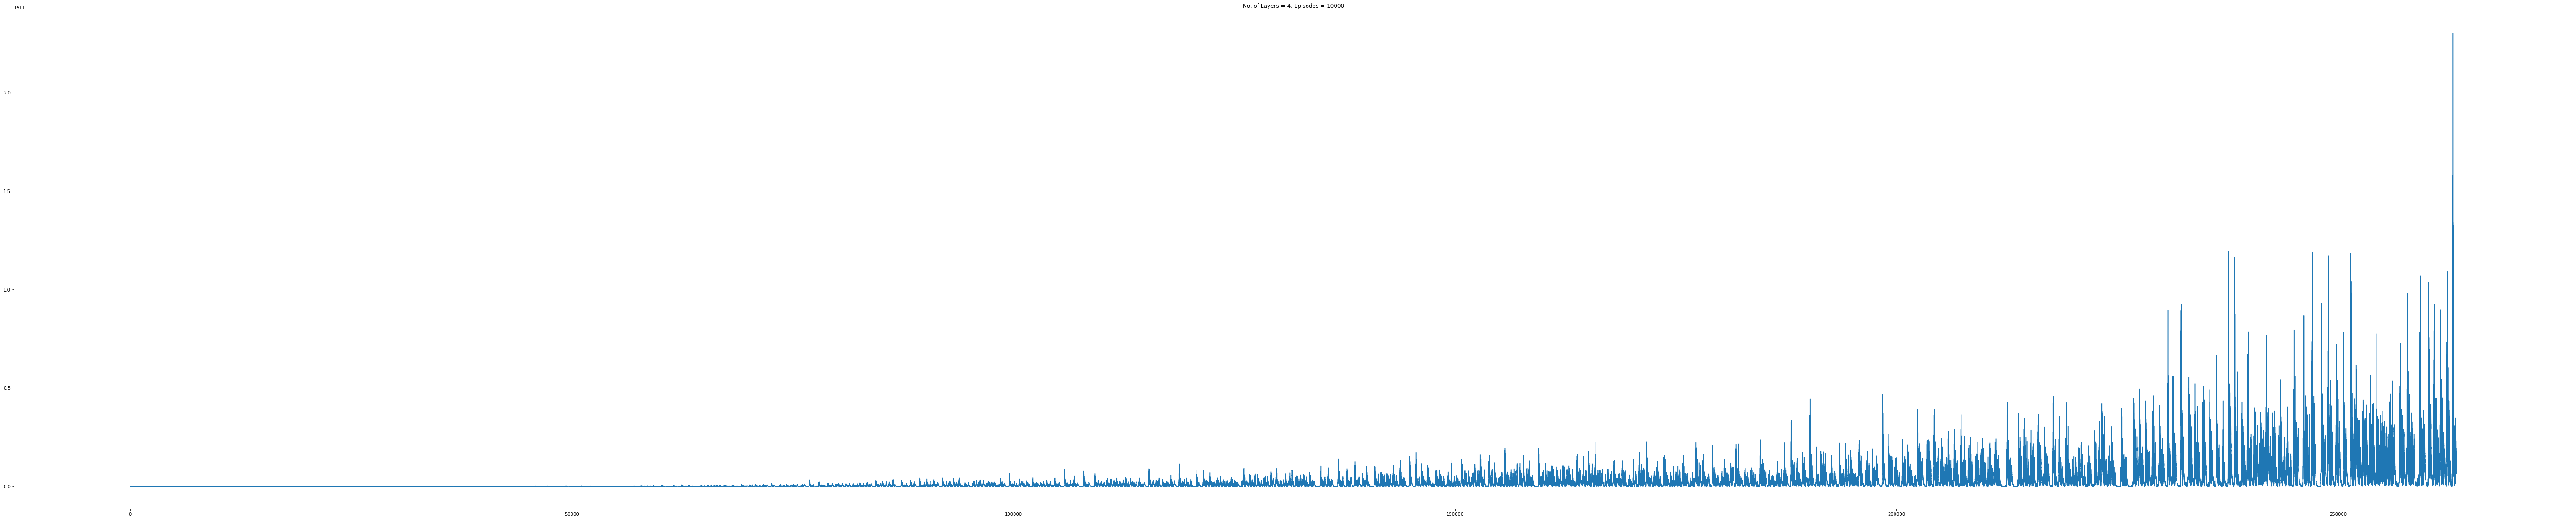

In [20]:
# loss = agent.get_loss()
plt.figure(figsize = (100,20))
plt.title(f'No. of Layers = 4, Episodes = {Episodes}')
plt.plot(loss)

In [27]:
f = open('Loss.pkl','rb')
pickle.load(f)

[21424.033203125,
 22018.51171875,
 15842.74609375,
 22636.599609375,
 38380.3984375,
 61490.015625,
 14341.025390625,
 35584.80078125,
 15283.666015625,
 15699.3115234375,
 4628.25341796875,
 6844.09716796875,
 21518.16796875,
 11624.9775390625,
 7755.45947265625,
 14807.3662109375,
 9549.0576171875,
 8085.31591796875,
 6611.830078125,
 41056.8671875,
 6907.1064453125,
 4756.4423828125,
 4169.9892578125,
 22537.857421875,
 32545.69921875,
 14058.43359375,
 14745.82421875,
 10098.765625,
 14113.0703125,
 5073.0283203125,
 14726.384765625,
 13622.212890625,
 4778.9248046875,
 15848.013671875,
 5778.33154296875,
 12889.8486328125,
 19637.78125,
 12201.10546875,
 27336.77734375,
 19915.310546875,
 26179.95703125,
 29112.806640625,
 22464.98828125,
 29255.10546875,
 26501.3515625,
 17175.19921875,
 27068.72265625,
 19175.533203125,
 17801.22265625,
 16613.56640625,
 17016.599609375,
 18068.373046875,
 15403.697265625,
 16266.7763671875,
 21907.25,
 11837.8291015625,
 16259.83203125,
 12408

In [24]:
pickle.load('State-Action Pairs.pkl')

TypeError: file must have 'read' and 'readline' attributes

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [96]:
time = np.arange(0,360000)
epsilon = []
decay = 4e-04#agent.epsilon_decay
for i in range(0,360000):
    epsilon.append(agent.epsilon_min + (agent.epsilon_max-agent.epsilon_min) * np.exp(-decay * i))


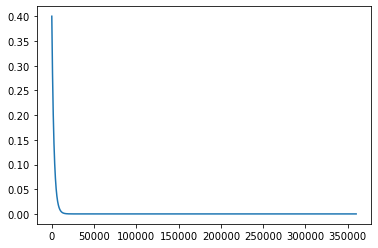

In [97]:
plt.plot(time, epsilon)
plt.show()

In [95]:
500*720

360000

In [99]:
1e4/60

166.66666666666666

In [ ]:
1e3/60